# **Model Testing and Evaluation**
This notebook covers model testing and evaluation for optimizing different model types.

In [1]:
# Change CWD to repo base for imports
import os
from pathlib import Path
notebook_path = Path().resolve()
parent_directory = notebook_path.parent
if notebook_path.cwd().__str__().split("/")[-1] != "theory_of_ml_group4":
    os.chdir(parent_directory)

# library imports
from etl import get_flight_data
from models import FlightPerformanceModel
import constants as c
# computation
import pandas as pd
import numpy as np
# model utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# models
from sklearn.linear_model import LogisticRegression, LinearRegression

import logging
log = logging.getLogger("modeling")
log.setLevel(logging.INFO)

# use this for dev
# from importlib import reload
# import models
# reload(models)
# from models import FlightPerformanceModel

In [2]:
df = get_flight_data(sample_frac=0.50)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

reading data/202312_flights.csv
reading data/202307_flights.csv
reading data/202402_flights.csv
reading data/202209_flights.csv
reading data/202302_flights.csv
reading data/202210_flights.csv
reading data/202308_flights.csv
reading data/202404_flights.csv
reading data/202301_flights.csv
skipped data/state_region_map.csv
reading data/202401_flights.csv
reading data/202304_flights.csv
reading data/202311_flights.csv
reading data/202406_flights.csv
reading data/202211_flights.csv
reading data/202303_flights.csv
reading data/202208_flights.csv
reading data/202403_flights.csv
reading data/202306_flights.csv
skipped data/airport_id_map.csv
reading data/202310_flights.csv
reading data/202305_flights.csv
reading data/202212_flights.csv
skipped data/airline_codes_map.csv
reading data/202405_flights.csv
reading data/202309_flights.csv
reading data/202207_flights.csv


# **Example of How to Use The Model**
The below is a simple example of how to use the model class

In [3]:
model = FlightPerformanceModel(
    targets = {
        c.CANCELLED_COL: {
            "type": "classification",
            "estimator": LogisticRegression,
            "params": {}
        },
        c.DELAYED_COL: {
            "type": "classification",
            "estimator": LogisticRegression,
            "params": {}
        },
        c.DELAY_DURATION_COL: {
            "type": "regression",
            "estimator": LinearRegression,
            "params": {}
        },
    },
)
model.fit(df_train.sample(frac=0.30, random_state=42))

Number of train rows with NaN: 0
17:19:19:Training model for target Cancelled
17:19:21:Model for target Cancelled trained.
17:19:21:Training model for target ArrDel15
17:19:22:Model for target ArrDel15 trained.
17:19:22:Training model for target ArrDelay
17:19:23:Model for target ArrDelay trained.


In [4]:
# Predict probabilities and calculate AUC for logistic regression model
for target_col in [c.CANCELLED_COL, c.DELAYED_COL]:
    y_pred_proba = model.predict_proba(df_test, target_col=target_col)
    logistic_auc = roc_auc_score(df_test[target_col].fillna(0), y_pred_proba)
    print(f"Logistic Regression AUC for {target_col}: {logistic_auc:.4f} vs. 0.50 baseline")

# Predict delay duration and calculate RMSE for linear regression model
y_true_delay_duration = df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL].fillna(0)
y_pred_delay_duration = model.predict(df_test.loc[(df_test[c.DELAYED_COL] == 1.0).values], target_col=c.DELAY_DURATION_COL)
linear_rmse = np.sqrt(np.mean((df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL] - y_pred_delay_duration)**2))
baseline_rmse = np.sqrt(np.mean(df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL]**2))
print(f"Linear Regression RMSE for {c.DELAY_DURATION_COL}: {linear_rmse:.4f} vs. {baseline_rmse:.4f} baseline")

Logistic Regression AUC for Cancelled: 0.6774 vs. 0.50 baseline
Logistic Regression AUC for ArrDel15: 0.6024 vs. 0.50 baseline
Linear Regression RMSE for ArrDelay: 98.4016 vs. 121.0417 baseline


# **Optimizing a Linear Model**

### **Do we need more train data?**

In [5]:
models = {}
for train_frac in [0.01, 0.05, 0.10, 0.25, 0.50, 1.0]:
    log.info(f"Fitting model with {train_frac:.0%} of training data")
    model = FlightPerformanceModel()
    model.fit(df_train.sample(frac=train_frac, random_state=42))
    models[train_frac] = {'model': model}

Fitting model with 1% of training data
Number of train rows with NaN: 0
17:19:27:Training model for target Cancelled
17:19:28:Model for target Cancelled trained.
17:19:28:Training model for target ArrDel15
17:19:28:Model for target ArrDel15 trained.
17:19:28:Training model for target ArrDelay
17:19:28:Model for target ArrDelay trained.
Fitting model with 5% of training data
Number of train rows with NaN: 0
17:19:29:Training model for target Cancelled
17:19:30:Model for target Cancelled trained.
17:19:30:Training model for target ArrDel15
17:19:30:Model for target ArrDel15 trained.
17:19:30:Training model for target ArrDelay
17:19:30:Model for target ArrDelay trained.
Fitting model with 10% of training data
Number of train rows with NaN: 0
17:19:33:Training model for target Cancelled
17:19:34:Model for target Cancelled trained.
17:19:34:Training model for target ArrDel15
17:19:34:Model for target ArrDel15 trained.
17:19:34:Training model for target ArrDelay
17:19:35:Model for target Arr

In [6]:
target_col = c.CANCELLED_COL
for train_frac in models.keys():
    log.info(f"Calculating AUC for {target_col} with {train_frac:.0%} of training data")
    model = models[train_frac]['model']
    aucs = []
    for bootstrap_num in range(20):
        df_test_bootstrap = df_test.sample(frac=1.0, replace=True, random_state=42+bootstrap_num)
        y_pred_proba = model.predict_proba(df_test_bootstrap, target_col=target_col)
        aucs.append(roc_auc_score(df_test_bootstrap[target_col].fillna(0), y_pred_proba))
    models[train_frac][f"{target_col}_auc"] = aucs

Calculating AUC for Cancelled with 1% of training data
Calculating AUC for Cancelled with 5% of training data
Calculating AUC for Cancelled with 10% of training data
Calculating AUC for Cancelled with 25% of training data
Calculating AUC for Cancelled with 50% of training data
Calculating AUC for Cancelled with 100% of training data


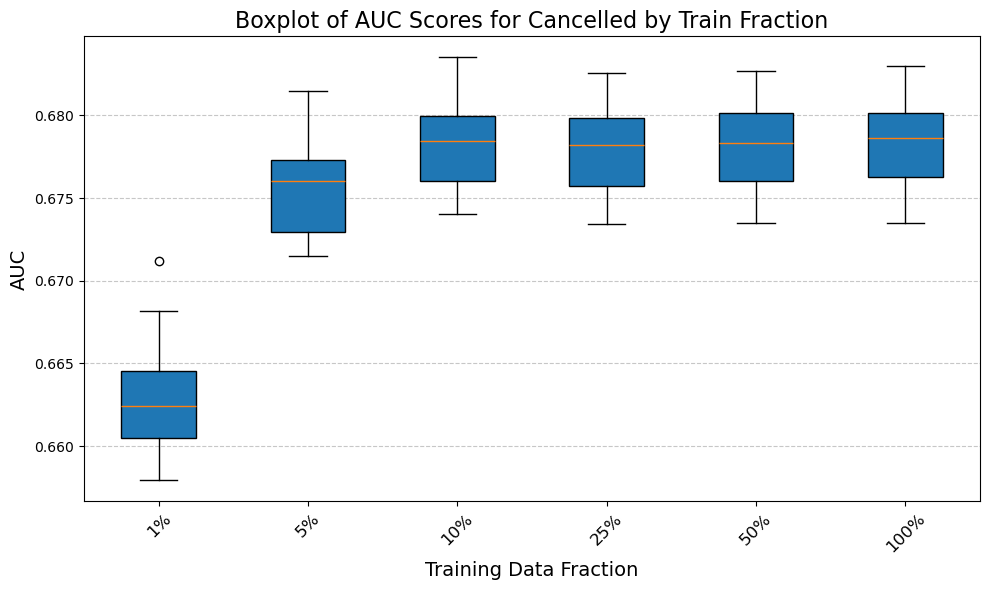

In [7]:
import matplotlib.pyplot as plt

auc_data = []
train_fractions = []
for train_frac in models.keys():
    aucs = models[train_frac][f"{target_col}_auc"]
    auc_data.append(aucs)  # Collect AUC values for each train fraction
    train_fractions.append(train_frac)

# Create the boxplot using Matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot(auc_data, labels=[f"{frac:.0%}" for frac in train_fractions], patch_artist=True)

# Customize the plot
plt.title(f"Boxplot of AUC Scores for {target_col} by Train Fraction", fontsize=16)
plt.xlabel("Training Data Fraction", fontsize=14)
plt.ylabel("AUC", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# **Feature Importances**

Number of train rows with NaN: 0
17:24:21:Training model for target Cancelled
17:24:23:Model for target Cancelled trained.
17:24:23:Training model for target ArrDel15
17:24:25:Model for target ArrDel15 trained.
17:24:25:Training model for target ArrDelay
17:24:25:Model for target ArrDelay trained.


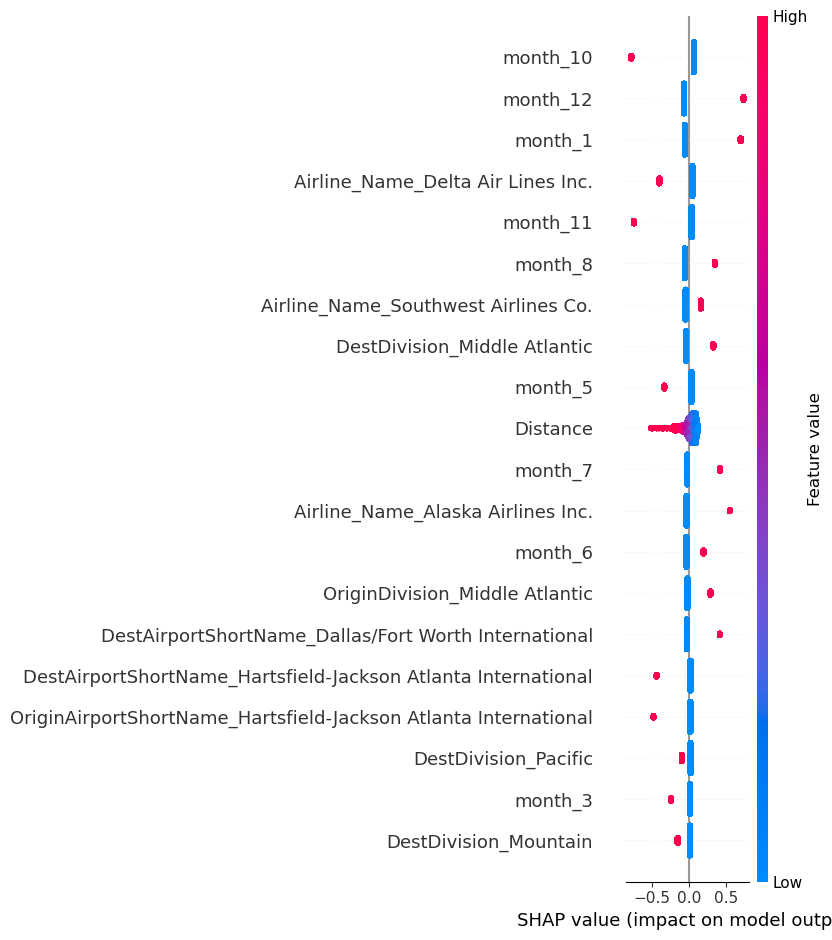

In [8]:
import shap

model = FlightPerformanceModel(
    targets = {
        c.CANCELLED_COL: {
            "type": "classification",
            "estimator": LogisticRegression,
            "params": {}
        },
        c.DELAYED_COL: {
            "type": "classification",
            "estimator": LogisticRegression,
            "params": {}
        },
        c.DELAY_DURATION_COL: {
            "type": "regression",
            "estimator": LinearRegression,
            "params": {}
        },
    },
)
model.fit(df_train.sample(frac=0.30, random_state=42))

X_test = model._transform_to_df(df_test)

# Create a SHAP explainer
explainer = shap.Explainer(model.estimators[c.CANCELLED_COL], X_test)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)
                        
# Summary plot of feature importance
# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
shap.summary_plot(shap_values, X_test)

/opt/anaconda3/envs/gradschool/lib/python3.12/site-packages/shap/plots/_force_matplotlib.py:321: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


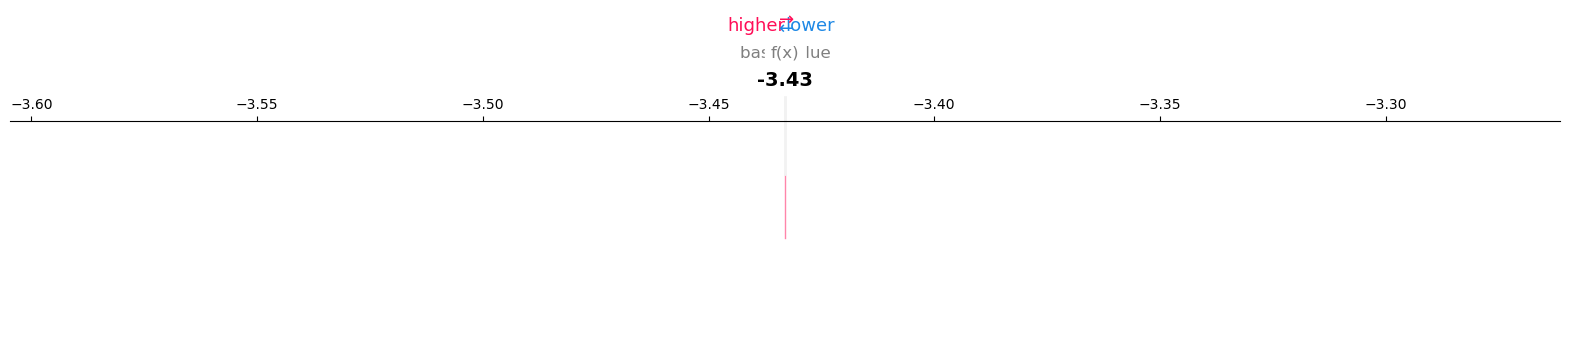

In [17]:
pred_df = pd.DataFrame({
    # origin
    "OriginAirportShortName": ["Dulles International Airport"],
    "OriginDivision": ["South Atlantic"],
    # destination
    "DestAirportShortName": ["Raleigh-Durham International"],
    "DestDivision": ["South Atlantic"],
    # flight features
    "Airline_Name": ["American Airlines Inc."],
    "Distance": [262],
    "ScheduledDurationMinutes": [1*60+19],
    # time features
    "FlightDate": ["2024-12-20"],
    "CRSDepTime": ["08:03"],
})

X_test = model._transform_to_df(pred_df)
shap_values = explainer(X_test)
explainer = shap.Explainer(model.estimators[c.CANCELLED_COL], X_test)

import numpy as np

# Number of top features to display
top_n = 10

# Get SHAP values for the individual instance
individual_shap_values = shap_values[0].values

# Sort features by absolute SHAP value and select the top-N
top_indices = np.argsort(np.abs(individual_shap_values))[-top_n:]

# Create a new DataFrame with only top features
X_test_top = X_test.iloc[0, top_indices]
shap_values_top = individual_shap_values[top_indices]

# Create a force plot with the top-N features
shap.force_plot(
    explainer.expected_value,
    shap_values_top,
    X_test_top,
    matplotlib=True
)


In [18]:
individual_shap_values

array([-0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
        0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,
        0., -0.,  0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,
       -0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,
       -0., -0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0., -0.])